## Navic Receiver Block

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from navicCAcodegen import genNavicCaCode as genCaCode
from navicCAcodegen import genNavicCaTable as genCaTable

### Initializations or Params

In [3]:
## Initialize block
msToProcess = int(40*1000)
numberOfChannels = 8
skipNumberOfBytes = 0

Gain = 2 # 1000

dataType = 'float32' # 'int8' # 'float32'

## sampled at 2.4MHz ie. Mega Samples per Second
samplingFreq = 2.4e6 # 2.4e6 
codeFreqBasis = 1023000.0
codeLength = 1023

Ts = 1/samplingFreq

prnTot = 14 # 14 for Navic 32 for GPS
acqSatelliteList = range(1, prnTot+1)
acqSearchBand = 14e3 ##  In Hz for balancing Doppler shift in freq
acqThreshold = 1.5 # 2.5

## required for seeking in tracking module
bytes_per_sample = 4


## Code Tracking params
dllDampingRatio = 0.7
dllNoiseBandwidth = 5.0 # 2.0
dllCorrelatorSpacing = 0.5

## Carrier tracking loop parameters
pllDampingRatio = 0.5
pllNoiseBandwidth = 30.0

# Period for calculating pseudoranges and position
navSolPeriod = 500.0 ## Corresponding to 50 bits/sec
elevationMask = 10.0
useTropCorr = True
truePosition = (np.nan,np.nan,np.nan)

## Some constant values
c = 299792458.0
startOffset = 0 #0 # 68.802

## Derived constants
samplesPerCode = np.long(np.round(samplingFreq / (codeFreqBasis / codeLength)))


## SDR front end part

In [4]:
file_i_dat = '/home/udhay/data/workspace/NavIC_receiver/raichur_data_rtlsdr/NavicL1_I_samp_120sec.bin'
file_q_dat = '/home/udhay/data/workspace/NavIC_receiver/raichur_data_rtlsdr/NavicL1_Q_samp_120sec.bin'

### Acquisition using Parallel Code Phase Search Acquisition

In [7]:
## Implementing Parallel Code Phase Search Acquisition

caCodeTable = genCaTable(samplingFreq)
## Get small time frame data
i_data = np.fromfile(file_i_dat,dataType,count=2*samplesPerCode)
q_data = np.fromfile(file_q_dat,dataType,count=2*samplesPerCode)

i_data[i_data<0] = -10
i_data[i_data>=0] = 10

q_data[q_data<0] = -10
q_data[q_data>=0] = 10

x_t = Gain * (i_data + 1j * q_data)

#x_t = (i_data - i_data.mean()) + 1j * (q_data - q_data.mean())

#x_t = x_t[:int(2**14)]

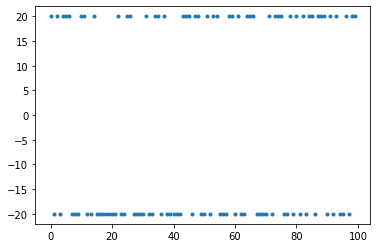

In [8]:
plt.plot(x_t[:100].real,'.')

In [9]:
def acquisition(PRN):
        caCode = caCodeTable[PRN,:]
        H_f = np.fft.fft(caCode).conj()

        n = np.arange(0,len(x_t))
        t_omega = 1j*2*pi*Ts*n
        
        results = np.zeros((len(freqBins),samplesPerCode))
        for findex in range(len(freqBins)):
            fd = freqBins[findex]
            g_t = x_t * np.exp(fd*t_omega)
            G1_f = np.fft.fft(g_t[:samplesPerCode])
            G2_f = np.fft.fft(g_t[:samplesPerCode])
            Y1_f = G1_f * H_f
            Y2_f = G2_f * H_f
            s1_t = abs(np.fft.ifft(Y1_f))**2
            s2_t = abs(np.fft.ifft(Y2_f))**2
            if s1_t.max() >= s2_t.max():
                results[findex] = s1_t
            else:
                results[findex] = s2_t
        ## For Peak metric
        frequencyBinIndex = results.max(1).argmax()
        peakSize = results.max(0).max()
        codePhase = results.max(0).argmax()
        samplesPerCodeChip = np.longlong(round(samplingFreq/codeFreqBasis))
        ## Get the peak from remaining sig power
        excludeRangeIndex1 = codePhase - samplesPerCodeChip
        excludeRangeIndex2 = codePhase + samplesPerCodeChip
        if excludeRangeIndex1 <= 0:
            codePhaseRange = np.r_[excludeRangeIndex2:samplesPerCode + excludeRangeIndex1 + 1]

        elif excludeRangeIndex2 >= samplesPerCode - 1:
            codePhaseRange = np.r_[excludeRangeIndex2 - samplesPerCode:excludeRangeIndex1]

        else:
            codePhaseRange = np.r_[0:excludeRangeIndex1 + 1, excludeRangeIndex2:samplesPerCode]

        ## Calculate peak metric
        secondPeakSize = results[frequencyBinIndex, codePhaseRange].max()
        print(f'firstPeak = {peakSize} , secondPeak = {secondPeakSize}')
        peakMetric[PRN] = peakSize / secondPeakSize
        ## Acquisition Result for each PRN
        if peakMetric[PRN] >= acqThreshold:
            codePhase_[PRN] = codePhase
            carrFreq[PRN] = freqBins[frequencyBinIndex]

In [10]:
freqBins = np.int16(np.arange(-acqSearchBand//2,acqSearchBand//2 + 1,step=50))

# Carrier frequencies of detected signals
carrFreq = np.zeros(prnTot)

# C/A code phases of detected signals
codePhase_ = np.zeros(prnTot)

# Correlation peak ratios of the detected signals
peakMetric = np.zeros(prnTot)

## Call Acquisiton routine
for PRN in range(prnTot):
    acquisition(PRN)

firstPeak = 25398534.63359537 , secondPeak = 16690440.990901574
firstPeak = 24752560.066268332 , secondPeak = 14280857.107571963
firstPeak = 26259282.347832646 , secondPeak = 13186344.916658588
firstPeak = 23201741.983238008 , secondPeak = 16741155.278784389
firstPeak = 24572514.479839887 , secondPeak = 20945593.913220827
firstPeak = 26884446.301375117 , secondPeak = 12873805.76014831
firstPeak = 23861383.89796119 , secondPeak = 17662617.81345564
firstPeak = 27370389.024455026 , secondPeak = 16274939.289470414
firstPeak = 27135113.605787218 , secondPeak = 18111094.5447838
firstPeak = 23792003.90846893 , secondPeak = 12904751.365619864
firstPeak = 23298312.728742965 , secondPeak = 16767233.39876163
firstPeak = 24051532.9223821 , secondPeak = 14694590.072963096
firstPeak = 26986983.449044034 , secondPeak = 17305351.441131245
firstPeak = 25738216.405084886 , secondPeak = 15486614.527138112


In [11]:
## Print Acquisition result:
print("Acquisition Results are :")

for PRN in range(prnTot):
    if peakMetric[PRN] >= acqThreshold:
            print(f'For PRN : {PRN} , CodePhase = {codePhase_[PRN]} , Peak Metric = {peakMetric[PRN]} and Doppler Freq = {carrFreq[PRN]} ')

Acquisition Results are :
For PRN : 0 , CodePhase = 1912.0 , Peak Metric = 1.5217413756437483 and Doppler Freq = -5000.0 
For PRN : 1 , CodePhase = 1844.0 , Peak Metric = 1.7332685202167653 and Doppler Freq = 4050.0 
For PRN : 2 , CodePhase = 2182.0 , Peak Metric = 1.9913996269473235 and Doppler Freq = 4650.0 
For PRN : 5 , CodePhase = 1176.0 , Peak Metric = 2.0883060380324863 and Doppler Freq = 5800.0 
For PRN : 7 , CodePhase = 609.0 , Peak Metric = 1.6817506067235017 and Doppler Freq = -3050.0 
For PRN : 9 , CodePhase = 1092.0 , Peak Metric = 1.8436623251691846 and Doppler Freq = 3500.0 
For PRN : 11 , CodePhase = 468.0 , Peak Metric = 1.6367610666890975 and Doppler Freq = -1700.0 
For PRN : 12 , CodePhase = 1613.0 , Peak Metric = 1.5594588495268318 and Doppler Freq = 6400.0 
For PRN : 13 , CodePhase = 1984.0 , Peak Metric = 1.6619653288317007 and Doppler Freq = 3900.0 


### Preparing for Tracking

In [12]:
## Sort the PRN according to Peak Metric (approx signal strength)
PRNindexes = sorted(enumerate(peakMetric),key=lambda x: x[-1], reverse=True)

## Total satellites we consider for tracking
sat_in_View = min(numberOfChannels,sum(peakMetric>=acqThreshold))

## Store the Tracking Sat PRN nums
PRN = np.zeros(sat_in_View,dtype=np.int)
acquiredFreq = np.zeros(sat_in_View)
codePhase = np.zeros(sat_in_View,dtype=np.int)
status = ['-' for _ in range(sat_in_View)]

for i in range(sat_in_View):
    sat_prn = PRNindexes[i][0]
    ## Actual Sat Number starts from 1
    PRN[i] = sat_prn + 1
    acquiredFreq[i] = carrFreq[sat_prn]
    codePhase[i] = codePhase_[sat_prn]
    status[i] = 'T'

## Create a channel data structure for easy access
channel = np.core.records.fromarrays([PRN, acquiredFreq, codePhase, status],
                                             names='PRN,acquiredFreq,codePhase,status')

In [13]:
# calcLoopCoef.m
def calcLoopCoef(LBW, zeta, k):
    # Function finds loop coefficients. The coefficients are used then in PLL-s
    # and DLL-s.
    # [tau1, tau2] = calcLoopCoef(LBW, zeta, k)
    #   Inputs:
    #       LBW           - Loop noise bandwidth
    #       zeta          - Damping ratio
    #       k             - Loop gain
    #   Outputs:
    #       tau1, tau2   - Loop filter coefficients
    
    # Solve for natural frequency
    Wn = LBW * 8.0 * zeta / (4.0 * zeta ** 2 + 1)

    # solve for t1 & t2
    tau1 = k / (Wn * Wn)

    tau2 = 2.0 * zeta / Wn

    return tau1, tau2

In [15]:
## Initialize Tracking variables
codePeriods = msToProcess

# --- DLL variables -----
# Define early-late offset (in chips)
earlyLateSpc = dllCorrelatorSpacing

# Summation interval
PDIcode = 0.001

# Calculate filter coefficient values
tau1code, tau2code = calcLoopCoef(dllNoiseBandwidth, dllDampingRatio, 1.0)

# --- PLL variables --------------------------------------------------------
# Summation interval
PDIcarr = 0.001

# Calculate filter coefficient values
tau1carr, tau2carr = calcLoopCoef(pllNoiseBandwidth, pllDampingRatio, 0.25)


# Initialize a temporary list of records
rec = []

In [16]:
## Start time is stored in file creation time itself
import pathlib,datetime
startTime = datetime.datetime.fromtimestamp(pathlib.Path(file_i_dat).stat().st_mtime)
startTime

datetime.datetime(2021, 5, 2, 12, 22, 36, 287107)

### Tracking Starts !

In [23]:
# Start processing channels

## open the whole if samples file for processing
ifid = open(file_i_dat,'rb')
qfid = open(file_q_dat,'rb')

for channelNr in range(sat_in_View):
    # Initialize fields for record(structured) array of tracked results
    status = '-'

    # The absolute sample in the record of the C/A code start:
    absoluteSample = np.zeros(msToProcess)

    # Freq of the C/A code:
    codeFreq_ = np.Inf * np.ones(msToProcess)

    # Frequency of the tracked carrier wave:
    carrFreq_ = np.Inf * np.ones(msToProcess)

    # Outputs from the correlators (In-phase):
    I_P_ = np.zeros(msToProcess)

    I_E_ = np.zeros(msToProcess)

    I_L_ = np.zeros(msToProcess)

    # Outputs from the correlators (Quadrature-phase):
    Q_E_ = np.zeros(msToProcess)

    Q_P_ = np.zeros(msToProcess)

    Q_L_ = np.zeros(msToProcess)

    # Loop discriminators
    dllDiscr = np.Inf * np.ones(msToProcess)

    dllDiscrFilt = np.Inf * np.ones(msToProcess)

    pllDiscr = np.Inf * np.ones(msToProcess)

    pllDiscrFilt = np.Inf * np.ones(msToProcess)

    PRN = 0

    # Only process if PRN is non zero (acquisition was successful)
    if channel[channelNr].PRN != 0:
        # Save additional information - each channel's tracked PRN
        PRN = channel[channelNr].PRN

        # continue signal processing at any point in the data record (e.g. for long
        # records). In addition skip through that data file to start at the
        # appropriate sample (corresponding to code phase). Assumes sample
        # type is schar (or 1 byte per sample)
        ifid.seek(skipNumberOfBytes * bytes_per_sample + channel[channelNr].codePhase * bytes_per_sample, 0)
        qfid.seek(skipNumberOfBytes * bytes_per_sample + channel[channelNr].codePhase * bytes_per_sample, 0)

        # Here PRN is the actual satellite ID instead of the 0-based index
        caCode = genCaCode(channel[channelNr].PRN - 1)

        caCode = np.r_[caCode[-1], caCode, caCode[0]]

        # define initial code frequency basis of NCO
        codeFreq = codeFreqBasis

        remCodePhase = 0.0

        carrFreq = channel[channelNr].acquiredFreq

        carrFreqBasis = channel[channelNr].acquiredFreq

        remCarrPhase = 0.0

        oldCodeNco = 0.0

        oldCodeError = 0.0

        oldCarrNco = 0.0

        oldCarrError = 0.0

        for loopCnt in range(np.long(codePeriods)):
            if loopCnt == 0:
                print(f'Tracking started for :{channelNr+1} of {sat_in_View} ; PRN is {PRN} in progress',end='')

            if loopCnt % 400 == 0:
                try:
                    print('#',end='')        
                finally:
                    pass
            # Read next block of data ------------------------------------------------
            # Find the size of a "block" or code period in whole samples
            # Update the phasestep based on code freq (variable) and
            # sampling frequency (fixed)
            codePhaseStep = codeFreq / samplingFreq

            blksize = np.ceil((codeLength - remCodePhase) / codePhaseStep)
            blksize = np.long(blksize)

            # interaction
            irawSignal = Gain * np.fromfile(ifid, dataType, blksize)
            qrawSignal = Gain * np.fromfile(qfid, dataType, blksize)
            
            samplesRead = len(irawSignal)

            # If did not read in enough samples, then could be out of
            # data - better exit
            if samplesRead != blksize:
                print ('Not able to read the specified number of samples for tracking, exiting!')
                fid.close()
                trackResults = None
                break
            # Set up all the code phase tracking information -------------------------
            # Define index into early code vector
            tcode = np.linspace(remCodePhase - earlyLateSpc,
                                blksize * codePhaseStep + remCodePhase - earlyLateSpc,
                                blksize, endpoint=False)

            tcode2 = np.ceil(tcode)

            earlyCode = caCode[np.int64(tcode2)]

            tcode = np.linspace(remCodePhase + earlyLateSpc,
                                blksize * codePhaseStep + remCodePhase + earlyLateSpc,
                                blksize, endpoint=False)

            tcode2 = np.ceil(tcode)

            lateCode = caCode[np.int64(tcode2)]

            tcode = np.linspace(remCodePhase,
                                blksize * codePhaseStep + remCodePhase,
                                blksize, endpoint=False)

            tcode2 = np.ceil(tcode)

            promptCode = caCode[np.int64(tcode2)]

            remCodePhase = tcode[blksize - 1] + codePhaseStep - 1023.0

            # Generate the carrier frequency to mix the signal to baseband -----------
            time = np.arange(0, blksize + 1)* Ts

            trigarg = carrFreq * 2.0 * pi * time + remCarrPhase

            remCarrPhase = trigarg[blksize] % (2 * pi)

            carrCos = np.cos(trigarg[0:blksize])

            carrSin = np.sin(trigarg[0:blksize])

            # Generate the six standard accumulated values ---------------------------
            # First mix to baseband
            iBasebandSignal = irawSignal[:] * carrCos - qrawSignal[:] * carrSin
            qBasebandSignal = irawSignal[:] * carrSin + qrawSignal[:] * carrCos
            
            I_E = (earlyCode * iBasebandSignal).sum()

            Q_E = (earlyCode * qBasebandSignal).sum()

            I_P = (promptCode * iBasebandSignal).sum()

            Q_P = (promptCode * qBasebandSignal).sum()

            I_L = (lateCode * iBasebandSignal).sum()

            Q_L = (lateCode * qBasebandSignal).sum()

            # Find PLL error and update carrier NCO ----------------------------------
            # Implement carrier loop discriminator (phase detector)
            carrError = np.arctan(Q_P / I_P) % (2.0 * np.pi)

            carrNco = oldCarrNco + \
                      tau2carr / tau1carr * (carrError - oldCarrError) + \
                      carrError * (PDIcarr / tau1carr)

            oldCarrNco = carrNco

            oldCarrError = carrError

            carrFreq = carrFreqBasis + carrNco

            carrFreq_[loopCnt] = carrFreq

            # Find DLL error and update code NCO -------------------------------------
            codeError = (np.sqrt(I_E * I_E + Q_E * Q_E) - np.sqrt(I_L * I_L + Q_L * Q_L)) / (
                    np.sqrt(I_E * I_E + Q_E * Q_E) + np.sqrt(I_L * I_L + Q_L * Q_L))

            codeNco = oldCodeNco + \
                      tau2code / tau1code * (codeError - oldCodeError) + \
                      codeError * (PDIcode / tau1code)

            oldCodeNco = codeNco

            oldCodeError = codeError

            codeFreq = codeFreqBasis - codeNco

            codeFreq_[loopCnt] = codeFreq

            # Record various measures to show in postprocessing ----------------------
            # Record sample number (based on 8bit samples)
            absoluteSample[loopCnt] = ifid.tell()

            dllDiscr[loopCnt] = codeError

            dllDiscrFilt[loopCnt] = codeNco

            pllDiscr[loopCnt] = carrError

            pllDiscrFilt[loopCnt] = carrNco

            I_E_[loopCnt] = I_E

            I_P_[loopCnt] = I_P

            I_L_[loopCnt] = I_L

            Q_E_[loopCnt] = Q_E

            Q_P_[loopCnt] = Q_P

            Q_L_[loopCnt] = Q_L
        print(' Done',end='\n')
        # If we got so far, this means that the tracking was successful
        # Now we only copy status, but it can be update by a lock detector
        # if implemented
        status = channel[channelNr].status
        rec.append((status, absoluteSample, codeFreq_, carrFreq_,
                    I_P_, I_E_, I_L_, Q_E_, Q_P_, Q_L_,
                    dllDiscr, dllDiscrFilt, pllDiscr, pllDiscrFilt, PRN))
print('\nTracking Process is Completed')
ifid.close()
qfid.close()

Tracking started for :1 of 8 ; PRN is 6 in progress#################################################################################################### Done
Tracking started for :2 of 8 ; PRN is 3 in progress#################################################################################################### Done
Tracking started for :3 of 8 ; PRN is 10 in progress#################################################################################################### Done
Tracking started for :4 of 8 ; PRN is 2 in progress#################################################################################################### Done
Tracking started for :5 of 8 ; PRN is 8 in progress#################################################################################################### Done
Tracking started for :6 of 8 ; PRN is 14 in progress#################################################################################################### Done
Tracking started for :7 of 8 ; PRN is 12 in progress####

### Store Tracking results

In [25]:
## Store tracking results in a Data structure
trackResults = np.rec.fromrecords(rec, dtype=[('status', 'S1'), ('absoluteSample', 'object'), ('codeFreq', 'object'),
                                                 ('carrFreq', 'object'), ('I_P', 'object'), ('I_E', 'object'),
                                                 ('I_L', 'object'),
                                                 ('Q_E', 'object'), ('Q_P', 'object'), ('Q_L', 'object'),
                                                 ('dllDiscr', 'object'),
                                                 ('dllDiscrFilt', 'object'), ('pllDiscr', 'object'),
                                                 ('pllDiscrFilt', 'object'),
                                                 ('PRN', 'int64')])
np.save('./trackResults.npy',trackResults)
print('Storing of Tracking Data is done for Extracting Navigation Data')

Storing of Tracking Data is done for Extracting Navigation Data
